In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob, os
import scipy.io as sio
from scipy.signal import savgol_filter
import random
from pyaldata import *

In [2]:
def process_monkey(data_dir, PMd):
    """
    Return concatenated monkey data after preprocessing
    """
    df = mat2dataframe(data_dir, shift_idx_fields=True)
    td = select_trials(df, "result == 'R'")
    td = select_trials(td, "epoch == 'BL'")
    td = add_firing_rates(td, 'smooth')
    #td = combine_time_bins(td,3)
    td = restrict_to_interval(td, "idx_movement_on", rel_start=-30, rel_end=40)
    if PMd == True:
        td = merge_signals(td, signals=['M1_rates', 'PMd_rates'], out_fieldname='both_rates')
        M1_data = concat_trials(td, 'both_rates')
    else:
        M1_data = concat_trials(td, 'M1_rates')

    return M1_data

def process_model(data_dir):
    fname = os.path.join(data_dir, "pydata.mat")

    df = mat2dataframe(fname, shift_idx_fields=True)

    df['bin_size']=0.1

    df['idx_trial_start'] = 0

   #df = combine_time_bins(df, 2)

    #df = restrict_to_interval(df,'idx_go_cue', rel_start=-30, rel_end=40, warn_per_trial=True)

    M1_data = concat_trials(df, 'MCx_rates')

    return M1_data


def corr_coef_sort(M1_data, n_neurons, n_it):
    C_sorted_sum = np.zeros((n_neurons, n_neurons))

    for i in range(n_it):
        C_sorted_sum = np.zeros((n_neurons, n_neurons))

        for i in range(n_it):
            # select subsample of random neurons
            idx = random.sample(range(M1_data.shape[1]), n_neurons)
            sample_data = M1_data[:,idx]
            # compute pairwise correlation 
            C = np.corrcoef(sample_data.T)
            # for each row in the matrix, sort the neurons (sort the absolute values before or after?)
            C_sum = np.zeros(C.shape)
            for j in range(sample_data.shape[1]):
                i_sort = np.argsort(C[:, j])
                
                C2 = C[:, i_sort]
                C2 = C2[i_sort,:]
                
                C_sum = C_sum + C2
            C_sorted_sum = C_sorted_sum + C_sum/n_neurons

        # average across iterations
        C_final = C_sorted_sum/n_it

        for i in range(n_neurons):
            C_final[i,i]=0 

    return C_final



# Import data 

In [3]:
data_dir_monkey = '/home/cf620/Documents/curved_manifold/data/monkey'
data_dir_model = '/home/cf620/git/prep_center_out/simulation/results/'
n_neurons = 40
n_it = 10


In [4]:

data_dic = np.load(os.getcwd()+'/monkey_dataset.npy', allow_pickle=True).item()

In [5]:
data_dic = {'Chewie': ['Chewie_CO_FF_2016-10-07',
  'Chewie_CO_CS_2016-10-21',
  'Chewie_CO_CS_2016-10-14',
  'Chewie_CO_FF_2016-09-15',
  'Chewie_CO_FF_2016-09-19',
  'Chewie_CO_FF_2016-09-21',
  'Chewie_CO_FF_2016-09-23',
  'Chewie_CO_FF_2016-10-05'],
 'Chewie2': ['Chewie_CO_CS_2015-11-06',
  'Chewie_CO_CS_2015-03-19',
  'Chewie_CO_CS_2015-03-13',
  'Chewie_CO_CS_2015-03-09',
  'Chewie_CO_CS_2015-03-11',
  'Chewie_CO_CS_2015-03-12',
  'Chewie_CO_FF_2015-07-01',
  'Chewie_CO_FF_2015-07-06'],
 'Mihili': ['Mihili_CO_VR_2014-03-03',
  'Mihili_CO_FF_2014-03-07',
  'Mihili_CO_FF_2014-02-18',
  'Mihili_CO_FF_2014-02-17',
  'Mihili_CO_FF_2014-02-03',
  'Mihili_CO_CS_2015-05-12',
  'Mihili_CO_CS_2014-09-29',
  'Mihili_CO_VR_2014-03-06']}

In [6]:
data_dic.keys()

dict_keys(['Chewie', 'Chewie2', 'Mihili'])

In [7]:
C_M = np.zeros((n_neurons,n_neurons,8))
C_C = np.zeros((n_neurons,n_neurons,8))
C_C2 = np.zeros((n_neurons,n_neurons,8))

C_M10 = np.zeros((n_neurons,n_neurons,8))
C_M40 = np.zeros((n_neurons,n_neurons,8))
C_M70 = np.zeros((n_neurons,n_neurons,8))
C_M100 = np.zeros((n_neurons,n_neurons,8))

CD_M10 = np.zeros((n_neurons,n_neurons,8))
CD_M40 = np.zeros((n_neurons,n_neurons,8))
CD_M70 = np.zeros((n_neurons,n_neurons,8))
CD_M100 = np.zeros((n_neurons,n_neurons,8))

In [8]:

for i in range(8):

    file = data_dic['Mihili'][i]
    M1_data = process_monkey(data_dir_monkey+'/Mihili/'+file, PMd=True)
    C_M[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    file = data_dic['Chewie'][i]
    M1_data = process_monkey(data_dir_monkey+'/Chewie/'+file, PMd=True)
    C_C[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    file = data_dic['Chewie2'][i]
    M1_data = process_monkey(data_dir_monkey+'/Chewie2/'+file, PMd=False)
    C_C2[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/1/')
    C_M10[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/2/')
    C_M40[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/3/')
    C_M70[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/4/')
    C_M100[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/5/')
    CD_M10[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/6/')
    CD_M40[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/7/')
    CD_M70[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

    M1_data = process_model(data_dir_model+'10002'+str(i+1)+'/8/')
    CD_M100[:,:,i]=corr_coef_sort(M1_data, n_neurons, n_it)

C_M = np.mean(C_M, axis=2)
C_C = np.mean(C_C, axis=2)
C_C2 = np.mean(C_C2, axis=2)

C_M10 = np.mean(C_M10, axis=2)
C_M40 = np.mean(C_M40, axis=2)
C_M70 = np.mean(C_M70, axis=2)
C_M100 = np.mean(C_M100, axis=2)

CD_M10 = np.mean(CD_M10, axis=2)
CD_M40 = np.mean(CD_M40, axis=2)
CD_M70 = np.mean(CD_M70, axis=2)
CD_M100 = np.mean(CD_M100, axis=2)

/home/cf620/anaconda3/envs/py-curved/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/cf620/anaconda3/envs/py-curved/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-2-1ab86e1ad990>:10: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [1157]
  td = restrict_to_interval(td, "idx_movement_on", rel_start=-30, rel_end=40)
<ipython-input-2-1ab86e1ad990>:10: UserWarning: Dropping the trials with the following IDs because of invalid time indexing. For more information, try warn_per_trial=True

        [ 64  75  88 106 111 113 138 203 210 219 243]
  td = restrict_to_interval(td, "idx_movement_on", rel_start=-30, rel_end=40)


In [9]:
h_M = np.nan_to_num(C_M[np.triu_indices(n_neurons-1)])
h_C = np.nan_to_num(C_C[np.triu_indices(n_neurons-1)])
h_C2 = C_C2[np.triu_indices(n_neurons-1)]
h_M10 = C_M10[np.triu_indices(n_neurons-1)]
h_M40 = C_M40[np.triu_indices(n_neurons-1)]
h_M70 = C_M70[np.triu_indices(n_neurons-1)]
h_M100 = C_M100[np.triu_indices(n_neurons-1)]

hD_M10 = CD_M10[np.triu_indices(n_neurons-1)]
hD_M40 = CD_M40[np.triu_indices(n_neurons-1)]
hD_M70 = CD_M70[np.triu_indices(n_neurons-1)]
hD_M100 = CD_M100[np.triu_indices(n_neurons-1)]

([<matplotlib.axis.XTick at 0x7f4e440fb130>,
 [Text(0, 0, 'Monkey M'),
  Text(1, 0, 'Monkey CR'),
  Text(2, 0, 'Monkey CL'),
  Text(3, 0, 'Model 10%'),
  Text(4, 0, 'Model 40%'),
  Text(5, 0, 'Model 70%'),
  Text(6, 0, 'Model 100%')])

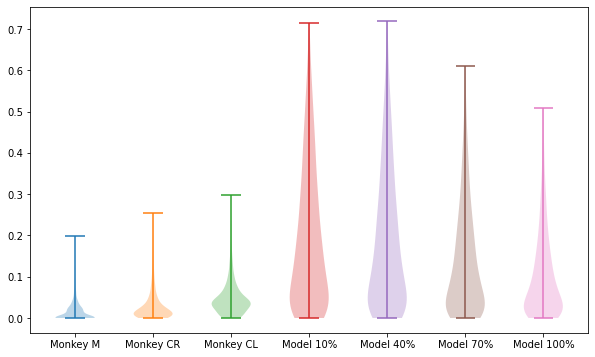

In [10]:
%matplotlib inline
labels=["Monkey M", "Monkey CR","Monkey CL", "Model 10%", "Model 40%", "Model 70%", "Model 100%"]

fig, ax = plt.subplots(figsize=(10, 6))
for i,arr in enumerate([abs(h_M), abs(h_C), abs(h_C2), abs(h_M10), abs(h_M40), abs(h_M70), abs(h_M100)]):
    ax.violinplot(dataset=arr,positions=[i],)
plt.xticks(range(len(labels)),labels)



([<matplotlib.axis.XTick at 0x7f4e43f08b20>,
 [Text(0, 0, 'Monkey M'),
  Text(1, 0, 'Monkey CR'),
  Text(2, 0, 'Monkey CL'),
  Text(3, 0, 'Model 10%'),
  Text(4, 0, 'Model 100%'),
  Text(5, 0, 'Decor 10%'),
  Text(6, 0, 'Decor 100%')])

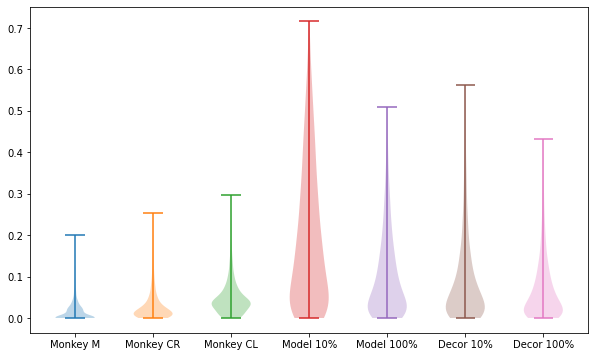

In [11]:
%matplotlib inline
labels=["Monkey M", "Monkey CR","Monkey CL", "Model 10%", "Model 100%", "Decor 10%", "Decor 100%"]

fig, ax = plt.subplots(figsize=(10, 6))
for i,arr in enumerate([abs(h_M), abs(h_C), abs(h_C2), abs(h_M10), abs(h_M100), abs(hD_M10), abs(hD_M100)]):
    ax.violinplot(dataset=arr,positions=[i],)
plt.xticks(range(len(labels)),labels)